In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from tqdm import tqdm
from collections import Counter

In [3]:
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

_____

### Dataset

In [4]:
df = pd.read_csv('new_reviews.csv')
df.shape

(73454, 4)

In [5]:
df.sample(5)

,ProductId,Score,Summary,Text
677,B00653KJ5M,4,"they are good (except for the ""rainforest"" fla...","These taste very good, but aren't like the BES..."
72968,B000GZS9Q6,4,great low carb option,These beans are great for people watching thei...
66989,B00954NY46,5,A good Bold coffee,This is a good strong coffee. Both my wife an...
35865,B001SB34RG,4,The skinny one,The ABC book and foodstore nearby temporarily ...
18451,B0041CIR62,3,Okay--but not great,I just purchased this product through Amazon. ...


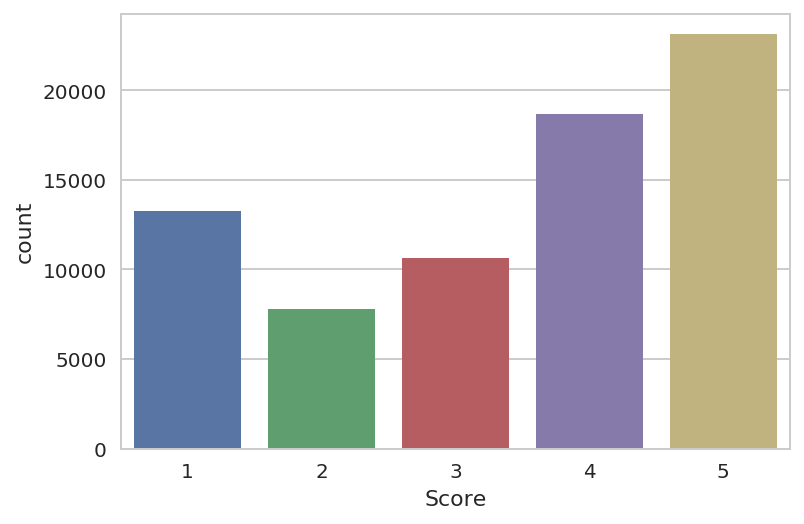

In [6]:
sns.countplot(df.Score)

### Pre-procesamiento de textos

In [7]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stopwords = stopwords.words('english')

In [8]:
#pre-procesamiento básico
def prep_text(text):
    #convertir a minusculas
    text = text.lower()
    
    #remover signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #remover stopwords y números
    tokens = [word for word in text.split(' ') if word not in stopwords] 
    
    #steaming(?) 
    
    return ' '.join(tokens)

In [9]:
sample_text = df.Text[10]
print(sample_text)
prep_text(sample_text)

I roast at home with a stove-top popcorn popper (but I do it outside, of course). These beans (Coffee Bean Direct Green Mexican Altura) seem to be well-suited for this method. The first and second cracks are distinct, and I've roasted the beans from medium to slightly dark with great results every time. The aroma is strong and persistent. The taste is smooth, velvety, yet lively.


'roast home stovetop popcorn popper outside course beans coffee bean direct green mexican altura seem wellsuited method first second cracks distinct ive roasted beans medium slightly dark great results every time aroma strong persistent taste smooth velvety yet lively'

In [10]:
df['prep_text'] = df.Text.apply(prep_text)
df['prep_summary'] = df.Summary.apply(prep_text)

In [11]:
df.sample(5)

,ProductId,Score,Summary,Text,prep_text,prep_summary
35267,B000G7TBUC,3,Pricey,I purchased these pretzels pretty often up unt...,purchased pretzels pretty often came back mak...,pricey
72727,B009AFJ548,5,Great no calorie sweetner especially for baking,I have been trying to eat healthier which invo...,trying eat healthier involve ingredients find ...,great calorie sweetner especially baking
54746,B005IPJTZE,2,Stick to the packets!,Don't waste your money on these cups...buy the...,dont waste money cupsbuy packets use keurigs s...,stick packets
47021,B000SATGHK,4,"Be still, My beating Heart","What I found ,after searching, was a Tea (or H...",found searching tea herb would help lower bloo...,still beating heart
24644,B001SIY414,5,Best mass marketed dried meat product ON EARTH,"I'm normally rather ""meh"" about beef jerky and...",im normally rather meh beef jerky similar prod...,best mass marketed dried meat product earth


### Data split

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['Score', 'prep_text']], test_size = 0.2, random_state=100)
train.shape, test.shape

((58763, 2), (14691, 2))

In [13]:
X_train = np.array(train["prep_text"])
X_test = np.array(test["prep_text"])
y_train = np.array(train["Score"])
y_test = np.array(test["Score"])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58763,), (14691,), (58763,), (14691,))

In [14]:
X_train[15]

'cookies fantastic  rich tasty  cookie contains rather large chocolate chunks  tony tiger would say great'

# Generación de carcaterísticas

## 1. TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(use_idf=True, max_features=300)
tfidf.fit(np.concatenate((X_train, X_test)))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=300,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [16]:
X_trainTFIDF = tfidf.transform(X_train)
X_testTFIDF = tfidf.transform(X_test)
X_trainTFIDF.shape, X_testTFIDF.shape

((58763, 300), (14691, 300))

## 2. Word Embeddings

In [ ]:
#Para instalar spacy
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-2.0.0/en_core_web_lg-2.0.0.tar.gz --user

In [17]:
import spacy
nlp = spacy.load('en_core_web_lg')

Documentación sobre los vectores pre-entrenados de spacy: https://spacy.io/usage/vectors-similarity#basics

In [18]:
X_trainWE = [nlp(doc).vector for doc in tqdm(X_train)]

100%|██████████| 58763/58763 [15:02<00:00, 65.14it/s]


In [19]:
X_testWE = [nlp(doc).vector for doc in tqdm(X_test)]

100%|██████████| 14691/14691 [03:37<00:00, 60.99it/s]


In [20]:
X_trainWE = np.array(X_trainWE)
X_testWE = np.array(X_testWE)
X_trainWE.shape, X_testWE.shape

((58763, 300), (14691, 300))

# Modelos de clasificación

In [21]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [22]:
def run_model(clf, X, y):
    scores = cross_val_score(clf, X, y, cv=5)
    print("%s accuracy: %0.2f (+/- %0.2f)" % \
          (str(clf.__class__).split('.')[-1].replace('>','').replace("'",''), 
          scores.mean(), scores.std() * 2))

In [23]:
#TF-IDF
run_model(RandomForestClassifier(), X_trainTFIDF, y_train)
run_model(LinearSVC(), X_trainTFIDF, y_train)

RandomForestClassifier accuracy: 0.51 (+/- 0.01)
LinearSVC accuracy: 0.49 (+/- 0.01)


In [24]:
#Word Vectors
run_model(RandomForestClassifier(), X_trainWE, y_train)
run_model(LinearSVC(), X_trainWE, y_train)

RandomForestClassifier accuracy: 0.48 (+/- 0.01)
LinearSVC accuracy: 0.51 (+/- 0.00)


- ¿Si se incluye el Summary en la descripción?
- ¿Mejorar pre procesmaiento?
- Analizar las palabras más frecuentes en cada clase
- Descartar oraciones muy cortas o muy largas ("outliers")
- ¿Mejorar parámetros del TF-IDF? (p.e menos dimensiones, considerar n-gramas)
- ¿Probar diferentes pre-procesamientos por cada tipo de representación?
- ¿Entrenar vectores de palabras "desde cero"? (https://radimrehurek.com/gensim/models/word2vec.html)
- Probar otro tipo de vectores pre-entrenados 
  (https://wikipedia2vec.github.io/wikipedia2vec/pretrained/, https://nlp.stanford.edu/projects/glove/, https://fasttext.cc/docs/en/english-vectors.html)
- Reducir dimensiones
- Agregar features dependiendo del texto (p.e análisis de sentimiento, cantidad de carcateres antes de pre-procesamiento, número de mayúsculas, entidades nombradas, POS Tagging)
- ¿Probar modelos más complejos?
- Transfer learning (https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/)